In [229]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
import re
import string
import numpy as np
import torch
from torch import Tensor

from nltk.corpus import stopwords
from stop_words import get_stop_words

def get_improved_russian_stopwords():
    """Улучшенный словарь стоп-слов, сохраняющий негативные контексты"""
    stop_words = set(get_stop_words('russian'))
    
    # УДАЛЯЕМ отрицательные слова из стоп-слов (очень важно!)
    negative_words_to_keep = {
        'не', 'нет', 'ни', 'никак', 'никогда', 'нисколько', 'ничуть',
        'отсутствует', 'плохо', 'ужасно', 'кошмар', 'отвратительно',
        'так себе', 'не очень', 'не понравилось', 'не нравится'
    }
    
    # Убираем отрицательные слова из стоп-слов
    stop_words = stop_words - negative_words_to_keep
    
    # Дополнительные стоп-слова для русского языка
    additional_stopwords = {
        'это', 'вот', 'как', 'так', 'и', 'в', 'над', 'к', 'до',
        'на', 'но', 'за', 'то', 'с', 'ли', 'а', 'во', 'от', 'со',
        'для', 'о', 'же', 'ну', 'вы', 'бы', 'что', 'кто', 'он', 'она'
    }
    
    return stop_words.union(additional_stopwords)
stop_words = get_improved_russian_stopwords()

def data_preprocessing(text: str) -> str:
    """preprocessing string: lowercase, removing html-tags, punctuation, 
                            stopwords, digits

    Args:
        text (str): input string for preprocessing

    Returns:
        str: preprocessed string
    """    

    text = text.lower()
    text = re.sub('<.*?>', '', text) # html tags
    text = ''.join([c for c in text if c not in string.punctuation])# Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([word for word in text.split() if not word.isdigit()]) 
    return text

def get_words_by_freq(sorted_words: list[tuple[str, int]], n: int = 10) -> list:
    return list(filter(lambda x: x[1] > n, sorted_words))

def padding(review_int: list, seq_len: int) -> np.array: # type: ignore
    """Make left-sided padding for input list of tokens

    Args:
        review_int (list): input list of tokens
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros

    Returns:
        np.array: padded sequences
    """    
    features = np.zeros((len(review_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
            
    return features

def preprocess_single_string(
    input_string: str, 
    seq_len: int, 
    vocab_to_int: dict,
    verbose : bool = False
    ) -> Tensor:
    """Function for all preprocessing steps on a single string

    Args:
        input_string (str): input single string for preprocessing
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros
        vocab_to_int (dict, optional): word corpus {'word' : int index}. Defaults to vocab_to_int.

    Returns:
        list: preprocessed string
    """    

    preprocessed_string = data_preprocessing(input_string)
    result_list = []
    for word in preprocessed_string.split():
        try: 
            result_list.append(vocab_to_int[word])
        except KeyError as e:
            if verbose:
                print(f'{e}: not in dictionary!')
            pass
    result_padded = padding([result_list], seq_len)[0]

    return Tensor(result_padded)

In [231]:
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt

#### Word2Vec
import gensim
from gensim.models import Word2Vec

####
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn
import torchutils as tu
from sklearn.model_selection import train_test_split
from collections import Counter

from torchmetrics.classification import BinaryAccuracy
# from src.rnn_preprocessing import (
#                                 data_preprocessing, 
#                                 preprocess_single_string, 
#                                 padding, 
#                                 get_words_by_freq
#                                 )
from src.train_rnn import train_attention_lstm

In [232]:
df = pd.read_json('/home/sokolov/Рабочий стол/ds_bootcamp/ds-phase-2/10-nlp/healthcare_facilities_reviews.jsonl',lines=True)

In [233]:
df['sentiment'].value_counts()

sentiment
positive    41419
negative    29178
Name: count, dtype: int64

In [234]:
df = df[['content','sentiment']]

In [235]:
df

,content,sentiment
0,Огромное спасибо за чудесное удаление двух зуб...,positive
1,Хочу выразить особую благодарность замечательн...,positive
2,Добрый вечер! Хотелось бы поблагодарить сотруд...,positive
3,Женщины советского образца в регистратуре не и...,negative
4,У меня с детства очень плохие зубы (тонкая и х...,positive
...,...,...
70592,Заведение ужасное. Врачи делят 1 кабинет на 2х...,negative
70593,"Люди, не обращайтесь в эту фирму! Муж проходил...",negative
70594,"Дорогие посетители медицинского центра ООО ""Ме...",positive
70595,"В регистратуре сидит хамка, такое отношение и ...",negative


In [236]:
content = df['content'].tolist()
preprocessed = [data_preprocessing(content) for content in content]

In [237]:
corpus = [word for text in preprocessed for word in text.split()]
sorted_words = Counter(corpus).most_common()
sorted_words = get_words_by_freq(sorted_words, 200)
sorted_words, len(sorted_words)

([('не', 157277),
  ('врач', 25215),
  ('нет', 13698),
  ('врача', 12440),
  ('врачи', 12092),
  ('хочу', 11922),
  ('ни', 11726),
  ('отношение', 10846),
  ('врачу', 9845),
  ('врачей', 9136),
  ('благодарность', 8510),
  ('лечение', 8500),
  ('огромное', 8151),
  ('ребенка', 7859),
  ('вообще', 7799),
  ('клинике', 7719),
  ('узи', 7525),
  ('прием', 7343),
  ('клинику', 7249),
  ('сразу', 7189),
  ('деньги', 7075),
  ('доктор', 7064),
  ('анализы', 6286),
  ('отделения', 6055),
  ('лечения', 5818),
  ('пришла', 5716),
  ('сказали', 5677),
  ('большое', 5658),
  ('клиники', 5529),
  ('персонал', 5498),
  ('зуб', 5481),
  ('отделении', 5305),
  ('делать', 5261),
  ('сделали', 5095),
  ('могу', 5040),
  ('мед', 5015),
  ('отделение', 4721),
  ('врачам', 4707),
  ('выразить', 4692),
  ('операции', 4656),
  ('больнице', 4655),
  ('диагноз', 4651),
  ('быстро', 4638),
  ('итоге', 4531),
  ('минут', 4500),
  ('операцию', 4483),
  ('больницу', 4362),
  ('ребенок', 4337),
  ('знаю', 4263),
 

In [238]:
# Создаем словарь слово: индекс
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}
vocab_to_int

{'не': 1,
 'врач': 2,
 'нет': 3,
 'врача': 4,
 'врачи': 5,
 'хочу': 6,
 'ни': 7,
 'отношение': 8,
 'врачу': 9,
 'врачей': 10,
 'благодарность': 11,
 'лечение': 12,
 'огромное': 13,
 'ребенка': 14,
 'вообще': 15,
 'клинике': 16,
 'узи': 17,
 'прием': 18,
 'клинику': 19,
 'сразу': 20,
 'деньги': 21,
 'доктор': 22,
 'анализы': 23,
 'отделения': 24,
 'лечения': 25,
 'пришла': 26,
 'сказали': 27,
 'большое': 28,
 'клиники': 29,
 'персонал': 30,
 'зуб': 31,
 'отделении': 32,
 'делать': 33,
 'сделали': 34,
 'могу': 35,
 'мед': 36,
 'отделение': 37,
 'врачам': 38,
 'выразить': 39,
 'операции': 40,
 'больнице': 41,
 'диагноз': 42,
 'быстро': 43,
 'итоге': 44,
 'минут': 45,
 'операцию': 46,
 'больницу': 47,
 'ребенок': 48,
 'знаю': 49,
 'никто': 50,
 'сделать': 51,
 'здоровья': 52,
 'таких': 53,
 'дня': 54,
 'работу': 55,
 'профессионализм': 56,
 'общем': 57,
 'поликлинике': 58,
 'доктора': 59,
 'больницы': 60,
 'моей': 61,
 'зубы': 62,
 'очереди': 63,
 'попала': 64,
 'пришлось': 65,
 'вопрос': 

In [239]:
reviews_int = []
for text in preprocessed:
    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)
print([i for i in reviews_int[0]])
print(preprocessed[0])

[13, 596, 197, 951, 22, 335, 186, 620, 552, 382, 742, 1462, 596, 20, 872, 184, 72, 1825, 167]
огромное чудесное удаление зубов мудрости мгновение доктор матвеев профессионал большой буквы боялась страшно заняло реально секунд согласилась удаление сразу второго зуба боли страха рекомендую


In [240]:
w2v_input = []
for review in preprocessed:
    cur_review = []
    for word in review.split():
        if vocab_to_int.get(word):
            cur_review.append(word)
    w2v_input.append(cur_review)
print(f'Total reviews: {len(w2v_input)}')
print(f'Random review for word2vec: {w2v_input[np.random.randint(0, 50000)]}')

Total reviews: 70597
Random review for word2vec: ['сделал', 'итоге', 'мере', 'полгода', 'не', 'беспокоит']


In [241]:
VOCAB_SIZE = len(vocab_to_int) + 1  # размер словаря вместе с токеном padding
EMBEDDING_DIM = 64 # embedding_dim 

In [242]:
# Обучим Word2Vec
wv = Word2Vec(
    vector_size=EMBEDDING_DIM # размерность вектора для слова
    )
# Сначала word2vec составляет словарь
wv.build_vocab(w2v_input)
print(f'Total reviews: {wv.corpus_count}')

Total reviews: 70597


In [243]:
# Далее обучаем
wv.train(
    corpus_iterable=w2v_input, 
    total_examples=wv.corpus_count, 
    epochs=10
    );

In [244]:
# Создаем слой эмбеддинга
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

# Бежим по всем словам словаря: если слово есть в word2vec, 
# достаем его вектор; если слова нет, то распечатываем его и пропускаем
for word, i in vocab_to_int.items():
    try:
        embedding_vector = wv.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError as e:
        pass
        print(f'{e}: word: {word}')
        
# Создаем предобученный эмбеддинг – этот слой в нашей сети обучаться не будет
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
print(f'Number of words x EMEDDING_DIM: {embedding_matrix.shape}')

Number of words x EMEDDING_DIM: (2979, 64)


In [245]:
# Применяем padding
padded = padding(review_int=reviews_int, seq_len=64)
print(padded[5])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   28 1720 2287  214  706    9  186  620  139  845  977 2177  184
   41 2396   47  423  143  176    1 1677 1720 2287   99   58  984  203
   60  114   91  112  190 2910  622 1346 2561    2  198   28  142 1837
 1073  240  433 1278    1 2178  535  739]


In [246]:
# train_test split + label encoding 
X_train, X_valid, y_train, y_valid = train_test_split(
    np.array(padded),
    pd.get_dummies(
        df['sentiment'], 
        drop_first=True
    ).values.astype('int'), test_size=0.2, random_state=1)

In [247]:
BATCH_SIZE = 64

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE)

In [248]:
# посмотрим, что внутри
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: BATCH_SIZE x SEQ_LEN', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y[:10])

Sample input size: BATCH_SIZE x SEQ_LEN torch.Size([64, 64])
Sample input: 
 tensor([[ 124, 1925, 2045,  ...,  353, 1042, 2611],
        [   0,    0,    0,  ...,  545,  521, 2489],
        [   6,   86,   24,  ...,  656,   83,   34],
        ...,
        [   0,    0,    0,  ...,  641, 1056, 2174],
        [   0,    0,    0,  ...,  169, 1780,  124],
        [   0,    0,    0,  ...,  147,   38, 2122]])
Sample input: 
 tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1]])


In [249]:
VOCAB_SIZE = len(vocab_to_int)+1 
SEQ_LEN = 32
BATCH_SIZE = 64
device='cpu'
HIDDEN_SIZE = 32

In [250]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.W = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)
    
    def forward(self, hidden, rnn_outputs):
        """
        Args:
            hidden: (batch_size, hidden_size) - последнее скрытое состояние
            rnn_outputs: (batch_size, seq_len, hidden_size) - все выходы RNN
        """
        # hidden: (batch_size, hidden_size) -> (batch_size, 1, hidden_size)
        hidden = hidden.unsqueeze(1)
        
        # Вычисляем скоры внимания
        # rnn_outputs: (batch_size, seq_len, hidden_size)
        # hidden: (batch_size, 1, hidden_size)
        
        scores = torch.tanh(self.W(rnn_outputs) + self.W(hidden))
        scores = self.V(scores).squeeze(-1)  # (batch_size, seq_len)
        
        # Веса внимания
        attention_weights = F.softmax(scores, dim=1)  # (batch_size, seq_len)
        
        # Взвешенная сумма - УБЕДИТЕСЬ ЧТО ФОРМЫ ПРАВИЛЬНЫЕ
        # attention_weights: (batch_size, 1, seq_len)
        # rnn_outputs: (batch_size, seq_len, hidden_size)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), rnn_outputs)
        context_vector = context_vector.squeeze(1)  # (batch_size, hidden_size)
        
        return context_vector, attention_weights

In [251]:
from dataclasses import dataclass
from typing import Union
@dataclass
class ConfigRNN:
    vocab_size: int
    device: str
    n_layers: int
    embedding_dim: int
    hidden_size: int
    seq_len: int
    bidirectional: Union[bool, int]
    embedding_dropout: float

In [252]:
net_config = ConfigRNN(
    vocab_size=len(vocab_to_int) + 1,
    device="cpu",
    n_layers=2,
    embedding_dim=16,
    hidden_size=32,
    seq_len=SEQ_LEN,
    bidirectional=False,
    embedding_dropout=0.2
)
net_config

ConfigRNN(vocab_size=2979, device='cpu', n_layers=2, embedding_dim=16, hidden_size=32, seq_len=32, bidirectional=False, embedding_dropout=0.2)

In [253]:
class RNNnetAttention(nn.Module):
    def __init__(self, rnn_conf=net_config):
        super().__init__()
        self.rnn_conf = rnn_conf
        self.vocab_size=rnn_conf.vocab_size
        self.n_layers=rnn_conf.n_layers
        self.emb_size=rnn_conf.embedding_dim
        self.hidden_dim=rnn_conf.hidden_size
        self.seq_len=rnn_conf.seq_len
        self.bidirectional=rnn_conf.bidirectional
        self.embedding_dropout=rnn_conf.embedding_dropout
        
        self.embedding = nn.Embedding(self.vocab_size,self.emb_size)
        self.attention = BahdanauAttention(self.hidden_dim * (2 if self.bidirectional else 1))
        self.embedding_dropout = nn.Dropout(self.embedding_dropout)
        self.rnn_cell = nn.RNN(
            input_size=self.emb_size,
            hidden_size=self.hidden_dim,
            batch_first=True,
            bidirectional=self.bidirectional,
            num_layers=self.n_layers
        )
        self.bidirect_factor=2 if self.bidirectional == 1 else 1
        self.linear=nn.Sequential(
            nn.Linear(self.hidden_dim * self.bidirect_factor, 32),
            nn.Dropout(0.4),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def model_description(self):
        direction = "bidirect" if self.bidirectional else "onedirect"
        return f"rnn_{direction}_{self.n_layers}"
    
    def forward(self, x):
        # Embedding (Word2Vec здесь работает!)
        x = self.embedding(x.to(self.rnn_conf.device))
        x = self.embedding_dropout(x)
        
        # RNN
        output, hidden = self.rnn_cell(x)
        
        # ВАЖНО: Получаем последнее скрытое состояние
        if self.bidirectional:
            # Для bidirectional объединяем forward и backward
            last_hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)  # (batch_size, hidden_dim*2)
        else:
            last_hidden = hidden[-1]  # (batch_size, hidden_dim)
        
        # Применяем внимание!
        context_vector, attention_weights = self.attention(last_hidden, output)
        
        # Классификация на основе context_vector
        out = self.linear(context_vector)
        
        return out, attention_weights  # возвращаем и предсказание, и веса внимания       

In [254]:
class LSTMnetAttention(nn.Module):
    def __init__(self, rnn_conf=net_config):
        super().__init__()
        self.rnn_conf = rnn_conf
        self.vocab_size = rnn_conf.vocab_size
        self.emb_size = rnn_conf.embedding_dim
        self.hidden_dim = rnn_conf.hidden_size
        
        # Увеличиваем размерность эмбеддингов для лучшего захвата семантики
        self.embedding = nn.Embedding(self.vocab_size, self.emb_size)
        
        # Используем LSTM вместо RNN - лучше запоминает долгосрочные зависимости
        self.rnn = nn.LSTM(
            input_size=self.emb_size,
            hidden_size=self.hidden_dim,
            batch_first=True,
            bidirectional=True,  # ВКЛЮЧАЕМ bidirectional для лучшего контекста
            num_layers=2,
            dropout=0.3
        )
        
        # Улучшенный механизм внимания
        self.attention = BahdanauAttention(self.hidden_dim * 2)
        
        # Более глубокая классификационная головка
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(), 
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # LSTM с packing для эффективности
        lstm_out, (hidden, cell) = self.rnn(x)
        
        # Для bidirectional LSTM объединяем последние состояния
        if self.rnn.bidirectional:
            last_hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        else:
            last_hidden = hidden[-1]
        
        # Attention с нормализацией
        context_vector, attention_weights = self.attention(last_hidden, lstm_out)
        
        # Классификация
        out = self.classifier(context_vector)
        
        return out, attention_weights  

In [255]:
model = LSTMnetAttention(net_config)
criterion = nn.BCEWithLogitsLoss()
optimizer_rnn = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
metric = BinaryAccuracy()

In [256]:
train_losses, val_losses, train_metric, val_metric, rnn_time = train_attention_lstm(
    7, model, train_loader, valid_loader, optimizer_rnn, criterion, metric
)

Epoch 1
train_loss : 0.5109 val_loss : 0.3639
train_accuracy : 0.74 val_accuracy : 0.84
Epoch 2
train_loss : 0.3121 val_loss : 0.2659
train_accuracy : 0.87 val_accuracy : 0.89
Epoch 3
train_loss : 0.2524 val_loss : 0.2342
train_accuracy : 0.90 val_accuracy : 0.91
Epoch 4
train_loss : 0.2225 val_loss : 0.2126
train_accuracy : 0.92 val_accuracy : 0.92
Epoch 5
train_loss : 0.2024 val_loss : 0.2075
train_accuracy : 0.93 val_accuracy : 0.92
Epoch 6
train_loss : 0.1880 val_loss : 0.1940
train_accuracy : 0.93 val_accuracy : 0.93
Epoch 7
train_loss : 0.1777 val_loss : 0.1880
train_accuracy : 0.94 val_accuracy : 0.93


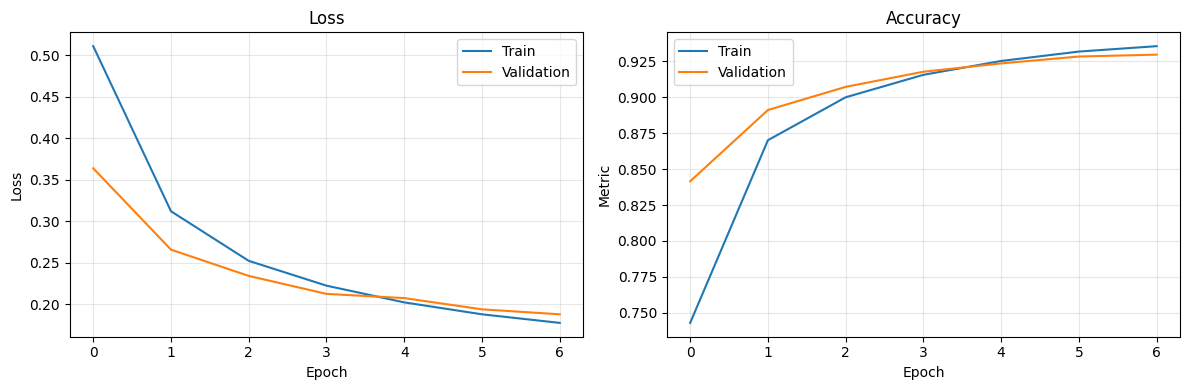

In [257]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_metric, label='Train')
plt.plot(val_metric, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [258]:
int_to_vocab = {j:i for i, j in vocab_to_int.items()}

In [259]:
def plot_and_predict(review, SEQ_LEN, model):
    # Препроцессинг текста
    processed_review = data_preprocessing(review)
    words = processed_review.split()[:SEQ_LEN]
    
    # Конвертируем слова в индексы
    sequence = []
    for word in words:
        if word in vocab_to_int:
            sequence.append(vocab_to_int[word])
        else:
            sequence.append(vocab_to_int['<UNK>'])  # если есть UNK токен
    
    # Добавляем padding если нужно
    if len(sequence) < SEQ_LEN:
        sequence = sequence + [0] * (SEQ_LEN - len(sequence))  # 0 = <PAD>
    
    # Создаем тензор
    inp = torch.tensor(sequence).unsqueeze(0)  # (1, seq_len)
    
    # Предсказание
    model.eval()
    with torch.no_grad():
        pred, att_weights = model(inp)
        pred_class = pred.sigmoid().round().item()
        att_scores = att_weights[0]  # (seq_len,)
    
    # Визуализация
    plt.figure(figsize=(12, 6))
    
    # Фильтруем padding токены
    valid_indices = [i for i, idx in enumerate(sequence) if idx != 0]  # индексы не-padding токенов
    valid_words = [int_to_vocab[sequence[i]] for i in valid_indices]
    valid_scores = att_scores[valid_indices]
    
    # График внимания
    plt.bar(range(len(valid_words)), valid_scores.cpu().numpy(), alpha=0.7, color='skyblue')
    plt.xticks(ticks=range(len(valid_words)), labels=valid_words, rotation=45, ha='right')
    plt.ylabel('Attention Weight')
    plt.title(f'Predicted class: {int(pred_class)} ({"Positive" if pred_class == 1 else "Negative"})')
    plt.tight_layout()
    plt.show()
    
    print(f"Review: {review}")
    print(f"Processed: {processed_review}")
    print(f"Prediction: {pred_class} (Probability: {pred.sigmoid().item():.4f})")
    print("\nTop words by attention:")
    for word, score in sorted(zip(valid_words, valid_scores.cpu().numpy()), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {word}: {score:.4f}")

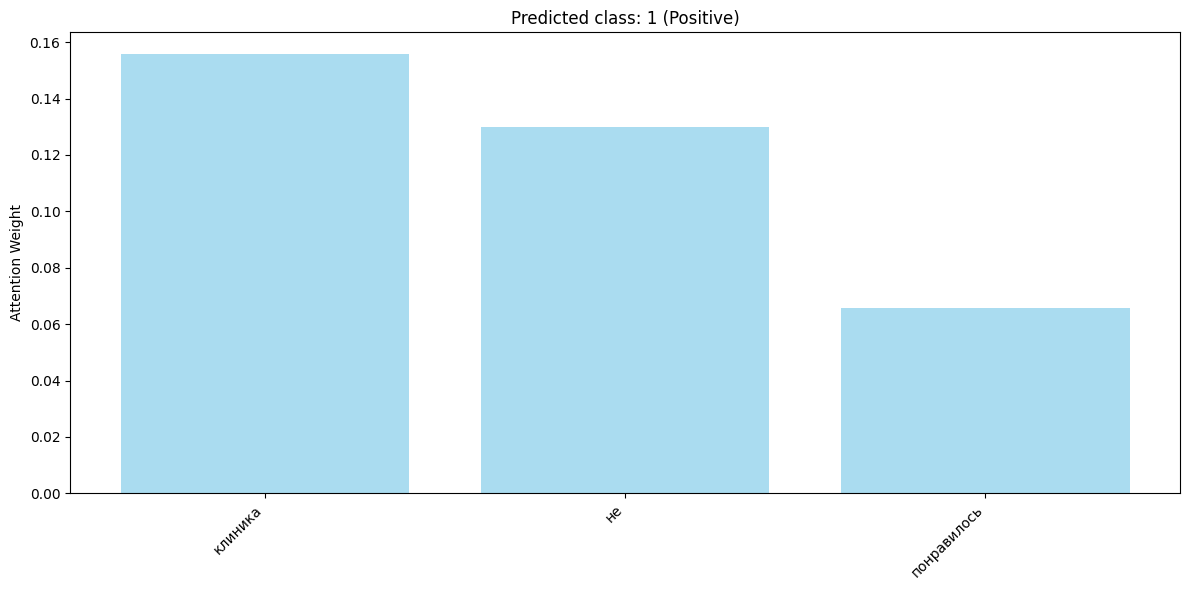

Review: Клиника так себе, мне не очень понравилось
Processed: клиника не понравилось
Prediction: 1.0 (Probability: 0.6803)

Top words by attention:
  клиника: 0.1557
  не: 0.1299
  понравилось: 0.0658


In [260]:
review = "Клиника так себе, мне не очень понравилось"
plot_and_predict(
    review = review, 
    SEQ_LEN=len(review.split()),
    model = model
)


In [261]:
def get_predictions(model, dataloader, device):
    """
    Получение предсказаний модели
    
    Args:
        model: обученная модель
        dataloader: DataLoader с данными
        device: устройство (cpu/cuda)
    
    Returns:
        all_predictions: numpy array с предсказаниями (0 или 1)
        all_probabilities: numpy array с вероятностями
        all_true: numpy array с истинными метками
        all_attention_weights: список тензоров с весами внимания
    """
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_true = []
    all_attention_weights = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Предполагаем, что batch содержит (inputs, labels)
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                inputs, labels = batch
            else:
                inputs = batch
                labels = None
            
            # Перенос на устройство
            inputs = inputs.to(device)
            
            # Прямой проход
            outputs, attention_weights = model(inputs)
            
            # Преобразуем в вероятности
            probabilities = torch.sigmoid(outputs).cpu().numpy().flatten()
            predictions = (probabilities > 0.5).astype(int)
            
            all_probabilities.extend(probabilities)
            all_predictions.extend(predictions)
            
            if labels is not None:
                all_true.extend(labels.cpu().numpy())
            
            # Сохраняем веса внимания
            all_attention_weights.append(attention_weights.cpu())
    
    return (
        np.array(all_predictions),
        np.array(all_probabilities),
        np.array(all_true) if all_true else None,
        torch.cat(all_attention_weights, dim=0) if all_attention_weights else None
    )

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import pandas as pd

def plot_confusion_matrix_with_metrics(y_true, y_pred, class_names=['Negative', 'Positive'], figsize=(10, 6)):
    """
    Построение confusion matrix с метриками
    
    Args:
        y_true: истинные метки
        y_pred: предсказанные метки  
        class_names: названия классов
        figsize: размер фигуры
    """
    
    # Вычисляем confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Создаем subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Confusion Matrix (абсолютные значения)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.4f}, F1: {f1:.4f}')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # Confusion Matrix (нормализованные значения)
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Confusion Matrix (Normalized)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Выводим classification report
    print("=" * 60)
    print("CLASSIFICATION REPORT")
    print("=" * 60)
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Детальная статистика
    print("=" * 60)
    print("DETAILED STATISTICS")
    print("=" * 60)
    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives:  {tn:4d}")
    print(f"False Positives: {fp:4d}")
    print(f"False Negatives: {fn:4d}") 
    print(f"True Positives:  {tp:4d}")
    print(f"Accuracy:        {accuracy:.4f}")
    print(f"F1-Score:        {f1:.4f}")
    print(f"Precision:       {tp/(tp+fp):.4f}" if (tp+fp) > 0 else "Precision:       0.0000")
    print(f"Recall:          {tp/(tp+fn):.4f}" if (tp+fn) > 0 else "Recall:          0.0000")
    
    return cm, accuracy, f1

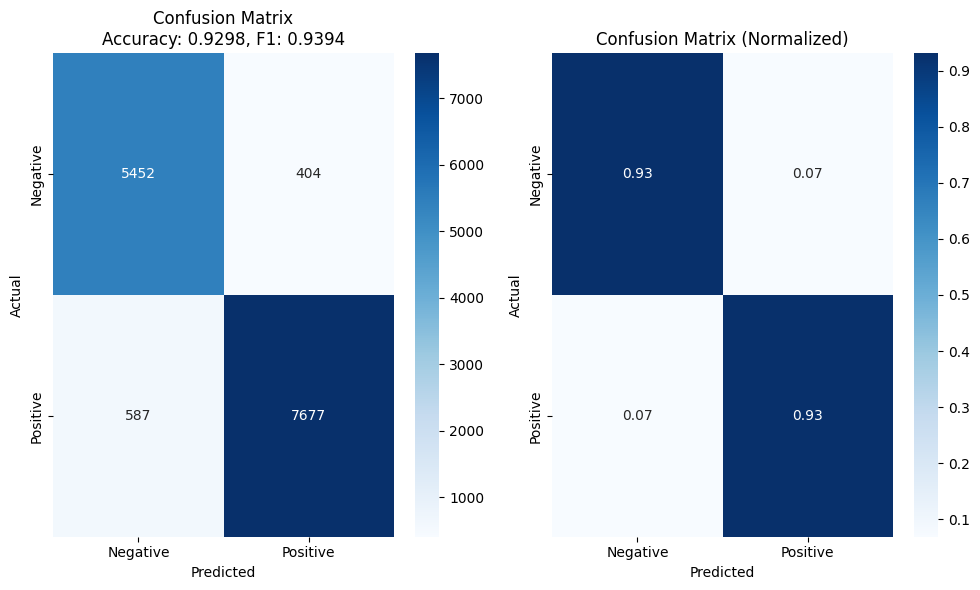

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.90      0.93      0.92      5856
    Positive       0.95      0.93      0.94      8264

    accuracy                           0.93     14120
   macro avg       0.93      0.93      0.93     14120
weighted avg       0.93      0.93      0.93     14120

DETAILED STATISTICS
True Negatives:  5452
False Positives:  404
False Negatives:  587
True Positives:  7677
Accuracy:        0.9298
F1-Score:        0.9394
Precision:       0.9500
Recall:          0.9290


In [267]:
def quick_eval(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    plot_confusion_matrix_with_metrics(np.array(all_labels), np.array(all_preds))

# Использование
quick_eval(model, valid_loader, device)